ここではオーバーサンプリング、K分割交差検証をおこなわない状態/行った状態でのモデルの精度を比較しています。以下掲載コードの内容
1. データ前処理
2. 必要ライブラリのインポート
3. 分類器の定義
4. オーバーサンプリング、K分割交差検証がない場合の各分類器のROC曲線
5. 各分類器の正解率のスコア
6. 各分類器の再現率のスコア
7. 各分類器のAUCのスコア
8. K分割交差検証だけ行った状態での正解率
9. 各分類器の再現率のスコア
10. 各分類器のROC曲線とAUCのスコア

結論：オーバーサンプリングが無い状態では、2クラスの分布が偏っているので正解率とAUCが指標として機能しない。
2クラスは非預金者：88％、預金者：12％の偏りなのでなにもしなくても、正解率がそれに比例して88～90％になる。
一方で再現率は下がってしまうので、これをなんとかするためにサンプリングを行った。



In [1]:
#オーバサンプリングせずに実践
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
df=pd.read_csv("train.csv")
df_dummy=pd.get_dummies(df[["job","marital","education",
                            "default","housing","loan",
                            "contact","month","poutcome","subscribed",
                            "age","balance","day","previous",
                            "duration","campaign","pdays"]],drop_first=True)
X,y=df_dummy.iloc[:,0:42],df_dummy.iloc[:,42].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)

In [5]:
#必要な機械学習のライブラリをインポート
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve,roc_auc_score,roc_curve,auc
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [3]:
#分類器の定義（チューニング前）
log=LogisticRegression(random_state=1)
dt=DecisionTreeClassifier(random_state=1)
knn=KNeighborsClassifier()
svc=SVC(probability=True)
rfc=RandomForestClassifier(random_state=1)
ada=AdaBoostClassifier(base_estimator=dt,random_state=1)
gb=GradientBoostingClassifier(random_state=1)
all_clf=[log,dt,knn,svc,rfc,ada,gb]
clf_labels=["Logistic Regression","DecisionTree","KNeighbor",
            "SVC","RandomForest","AdaBoost","GradientBoost"]

In [ ]:
#サンプリングなし、分割検証なしの場合のROC曲線
fig=plt.figure(figsize=(7,5))
colors=["blue","green","red","purple","orange","cyan","olive"]
for clf,label,clr in zip(all_clf,clf_labels,colors):
  y_pred=clf.fit(X_train,y_train).predict_proba(X_test)[:,1]
  fpr,tpr,thresholds=roc_curve(y_true=y_test,y_score=y_pred)
  roc_auc=auc(x=fpr,y=tpr)
  plt.plot(fpr,tpr,color=clr,label="%s(auc=%0.2f)"%(label,roc_auc))
plt.legend(loc="lower right")
plt.plot([0,0,1],[0,1,1],
         linestyle=":",color="black",label="Perfect Perfomance")
plt.plot([0,1],[0,1],linestyle="--",color="gray",linewidth=2,label="Random Guessing")
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show

In [ ]:
#正解率のスコア
from sklearn.metrics import accuracy_score
for clf,label in zip(all_clf,clf_labels):
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  scores=accuracy_score(y_test,y_pred)
  print("accuracy: %0.2f(+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))

In [ ]:
#再現率のスコア
from sklearn.metrics import recall_score
for clf,label in zip(all_clf,clf_labels):
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  scores=recall_score(y_test,y_pred)
  print("recall: %0.2f(+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))

In [ ]:
#roc_aucのスコア（AUC）
from sklearn.metrics import roc_auc_score
for clf,label in zip(all_clf,clf_labels):
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  scores=roc_auc_score(y_test,y_pred)
  print("roc_auc: %0.2f(+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))

In [ ]:
#サンプリングなし、交差検証ありの場合。正解率
for clf,label in zip(all_clf,clf_labels):
  scores=cross_val_score(estimator=clf,
                         X=X_train,y=y_train,cv=5,
                         scoring="accuracy")
  print("accuracy: %0.2f(+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))
#正解率も大きく改善しなかった。

In [ ]:
#サンプリングなし、交差検証ありの場合。再現率
for clf,label in zip(all_clf,clf_labels):
  scores=cross_val_score(estimator=clf,
                         X=X_train,y=y_train,cv=5,
                         scoring="recall")
  print("recall: %0.2f(+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))
#交差検証をしても再現率は改善せず……。

<ipython-input-6-f9dcf8a4374e>:12: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr_log+=interp(mean_fpr_log,fpr_log,tpr_log)
<ipython-input-6-f9dcf8a4374e>:12: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr_log+=interp(mean_fpr_log,fpr_log,tpr_log)
<ipython-input-6-f9dcf8a4374e>:12: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr_log+=interp(mean_fpr_log,fpr_log,tpr_log)
<ipython-input-6-f9dcf8a4374e>:12: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr_log+=interp(mean_fpr_log,fpr_log,tpr_log)
<ipython-input-6-f9dcf8a4374e>:12: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr_log+=interp(mean_fpr_log,fpr_log,tpr_log)
<ipython-input-6-f9d

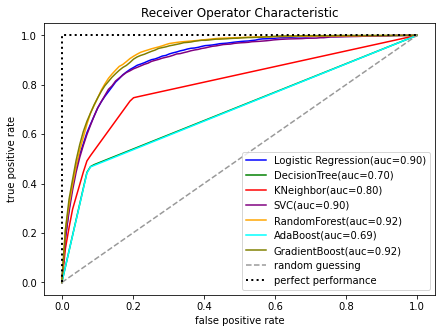

In [6]:
#オーバーサンプリングなし、交差検証ありのROC曲線とAUCの値
from sklearn.model_selection import StratifiedKFold
from scipy import interp
cv=list(StratifiedKFold(n_splits=5).split(X_train,y_train))
fig = plt.figure(figsize=(7,5))
#logistic
mean_fpr_log=np.linspace(0,1,100)
mean_tpr_log= 0.0
for i,(train, test) in enumerate(cv):
  probas=log.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
  fpr_log,tpr_log,thresholds_log=roc_curve(y_train[test], probas[:, 1], pos_label=1)
  mean_tpr_log+=interp(mean_fpr_log,fpr_log,tpr_log)
  mean_tpr_log[0]=0
  roc_auc_log=auc(fpr_log, tpr_log)
mean_tpr_log=mean_tpr_log/len(cv)
mean_auc_log=auc(mean_fpr_log, mean_tpr_log)
plt.plot(mean_fpr_log, mean_tpr_log,color="blue",
         label="%s(auc=%0.2f)"%(clf_labels[0],mean_auc_log))
#decisiontree
mean_fpr_dt=np.linspace(0,1,100)
mean_tpr_dt=0.0
for i,(train, test) in enumerate(cv):
  probas=dt.fit(X_train[train],y_train[train]).predict_proba(X_train[test])
  fpr_dt,tpr_dt,thresholds_dt=roc_curve(y_train[test],probas[:,1],pos_label=1)
  mean_tpr_dt+=interp(mean_fpr_dt,fpr_dt,tpr_dt)
  mean_tpr_dt[0]=0
  roc_auc_dt=auc(fpr_dt,tpr_dt)
mean_tpr_dt=mean_tpr_dt/len(cv)
mean_auc_dt=auc(mean_fpr_dt,mean_tpr_dt)
plt.plot(mean_fpr_dt,mean_tpr_dt,color="green",label="%s(auc=%0.2f)"%(clf_labels[1],mean_auc_dt))
#kneighbor
mean_fpr_knn=np.linspace(0,1,100)
mean_tpr_knn=0.0
for i,(train, test) in enumerate(cv):
  probas=knn.fit(X_train[train],y_train[train]).predict_proba(X_train[test])
  fpr_knn,tpr_knn,thresholds_knn=roc_curve(y_train[test],probas[:,1],pos_label=1)
  mean_tpr_knn+=interp(mean_fpr_knn,fpr_knn,tpr_knn)
  mean_tpr_knn[0]=0
  roc_auc_knn=auc(fpr_knn, tpr_knn)
mean_tpr_knn=mean_tpr_knn/len(cv)
mean_auc_knn=auc(mean_fpr_knn,mean_tpr_knn)
plt.plot(mean_fpr_knn,mean_tpr_knn,color="red",
         label="%s(auc=%0.2f)"%(clf_labels[2],mean_auc_knn))
#SVC
mean_fpr_svc=np.linspace(0,1,100)
mean_tpr_svc=0.0
for i,(train, test) in enumerate(cv):
  probas=svc.fit(X_train[train],y_train[train]).predict_proba(X_train[test])
  fpr_svc,tpr_svc,thresholds_svc=roc_curve(y_train[test],probas[:,1],pos_label=1)
  mean_tpr_svc+=interp(mean_fpr_svc,fpr_svc,tpr_svc)
  mean_tpr_svc[0]=0
  roc_auc_svc=auc(fpr_svc,tpr_svc)
mean_tpr_svc=mean_tpr_svc/len(cv)
mean_auc_svc=auc(mean_fpr_svc,mean_tpr_svc)
plt.plot(mean_fpr_svc,mean_tpr_svc,color="purple",
         label="%s(auc=%0.2f)"%(clf_labels[3],mean_auc_svc))
#randomforest
mean_fpr_rfc=np.linspace(0,1,100)
mean_tpr_rfc=0.0
for i,(train, test) in enumerate(cv):
  probas=rfc.fit(X_train[train],y_train[train]).predict_proba(X_train[test])
  fpr_rfc,tpr_rfc,thresholds_rfc=roc_curve(y_train[test],probas[:,1],pos_label=1)
  mean_tpr_rfc+=interp(mean_fpr_rfc,fpr_rfc,tpr_rfc)
  mean_tpr_rfc[0]=0
  roc_auc_rfc=auc(fpr_rfc,tpr_rfc)
mean_tpr_rfc=mean_tpr_rfc/len(cv)
mean_auc_rfc=auc(mean_fpr_rfc,mean_tpr_rfc)
plt.plot(mean_fpr_rfc,mean_tpr_rfc,color="orange",
         label="%s(auc=%0.2f)"%(clf_labels[4],mean_auc_rfc))
#adaboost
mean_fpr_ada=np.linspace(0,1,100)
mean_tpr_ada=0.0
for i,(train,test) in enumerate(cv):
  probas=ada.fit(X_train[train],y_train[train]).predict_proba(X_train[test])
  fpr_ada,tpr_ada,thresholds_ada=roc_curve(y_train[test],probas[:,1],pos_label=1)
  mean_tpr_ada+=interp(mean_fpr_ada,fpr_ada,tpr_ada)
  mean_tpr_ada[0]=0
  roc_auc_ada=auc(fpr_ada,tpr_ada)
mean_tpr_ada=mean_tpr_ada/len(cv)
mean_auc_ada=auc(mean_fpr_ada,mean_tpr_ada)
plt.plot(mean_fpr_ada,mean_tpr_ada,color="cyan",
         label="%s(auc=%0.2f)"%(clf_labels[5],mean_auc_ada))
#gradientboost
mean_fpr_gb=np.linspace(0,1,100)
mean_tpr_gb=0.0
for i,(train, test) in enumerate(cv):
  probas=gb.fit(X_train[train],y_train[train]).predict_proba(X_train[test])
  fpr_gb,tpr_gb,thresholds_gb=roc_curve(y_train[test],probas[:,1],pos_label=1)
  mean_tpr_gb+=interp(mean_fpr_gb,fpr_gb,tpr_gb)
  mean_tpr_gb[0]=0
  roc_auc_gb=auc(fpr_gb,tpr_gb)
mean_tpr_gb=mean_tpr_gb/len(cv)
mean_auc_gb=auc(mean_fpr_gb,mean_tpr_gb)
plt.plot(mean_fpr_gb,mean_tpr_gb,color="olive",
         label="%s(auc=%0.2f)"%(clf_labels[6],mean_auc_gb))
#当て推量
plt.plot([0, 1], [0, 1],linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
#予測が完全的中した場合
plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()